**Importing Necessary Libraries**

In [1]:
import re
import pandas as pd
import numpy as np
import nltk

In [2]:

from nltk.corpus import stopwords

**Fetching the data** (the data has been preprocessed already)

Preprocessing steps include: 
1. Lemmatization
2. Stop Word Removal
3. Removing html tags and urls

In [3]:
from google.colab import files
data = files.upload()

Saving Final_data.csv to Final_data.csv


In [4]:
data = pd.read_csv('Final_data.csv')

**Preparing the data**

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [6]:
reviews = data['Reviews'].values
labels = data['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [7]:
vocab = 10000
max_length = 500
embedding_dim = 50

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [9]:
tokenizer = Tokenizer(lower=False, split=' ', oov_token=None, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(reviews)
X_vocab = {"<PAD>":0}
X_vocab.update(tokenizer.word_index)


all_text2seq= tokenizer.texts_to_sequences(reviews)

padded_seq = pad_sequences(all_text2seq,  maxlen=500, padding="post", truncating="post")

In [10]:
X_train, X_test, train_labels, test_labels = train_test_split(padded_seq, encoded_labels, stratify = encoded_labels)

**Creating the model architecture**

In [11]:
import tensorflow as tf
import keras


In [12]:
lstm_model = keras.Sequential([
    keras.layers.Embedding(len(X_vocab), embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(16)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


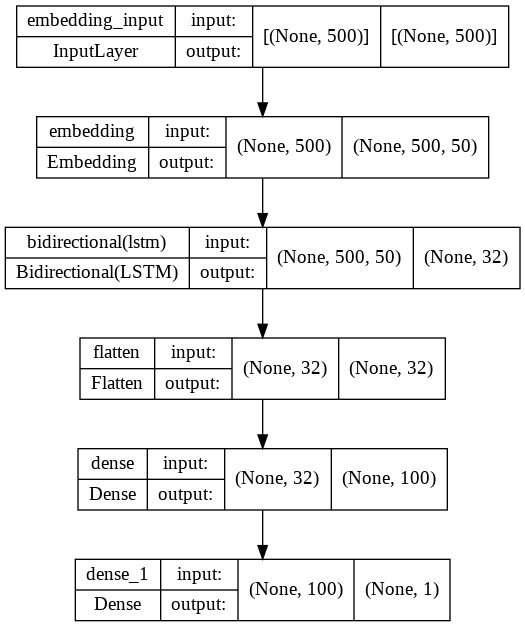

In [13]:
tf.keras.utils.plot_model(
    lstm_model,
    to_file="lstm_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [14]:

lstm_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [15]:
lstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           4577900   
                                                                 
 bidirectional (Bidirectiona  (None, 32)               8576      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 100)               3300      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 4,589,877
Trainable params: 4,589,877
Non-trainable params: 0
______________________________________________

**Training**

In [16]:
import h5py

In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 200)
mcp = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) 

In [19]:
num_epochs = 20
history = lstm_model.fit(X_train, train_labels, 
                    epochs=num_epochs, validation_data = ([X_test[:6250]], [test_labels[:6250]]), callbacks = [es,mcp])

Epoch 1/20
1172/1172 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.8479
Epoch 1: val_accuracy improved from -inf to 0.87712, saving model to best_model.h5
1172/1172 [==============================] - 260s 219ms/step - loss: 0.3487 - accuracy: 0.8479 - val_loss: 0.3199 - val_accuracy: 0.8771
Epoch 2/20
1172/1172 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.9184
Epoch 2: val_accuracy improved from 0.87712 to 0.89328, saving model to best_model.h5
1172/1172 [==============================] - 258s 220ms/step - loss: 0.2189 - accuracy: 0.9184 - val_loss: 0.2686 - val_accuracy: 0.8933
Epoch 3/20
1172/1172 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.9328
Epoch 3: val_accuracy did not improve from 0.89328
1172/1172 [==============================] - 259s 221ms/step - loss: 0.1835 - accuracy: 0.9328 - val_loss: 0.4255 - val_accuracy: 0.8680
Epoch 4/20
1172/1172 [==============================] - ETA: 0s - loss: 0.1

**Learning Curves**

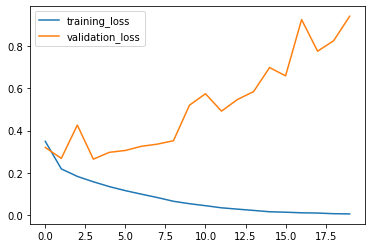

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

**Predictions on the test data (unseen data)**

In [21]:
from keras.models import load_model

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score, f1_score

In [23]:
# load the saved model (best model)
saved_model = load_model('best_model.h5')

In [24]:
prediction = saved_model.predict(X_test[6250:])
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels[6250:],pred_labels))


Accuracy of prediction on test set :  0.89136


In [25]:
print(classification_report(test_labels[6250:],pred_labels))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3114
           1       0.89      0.89      0.89      3136

    accuracy                           0.89      6250
   macro avg       0.89      0.89      0.89      6250
weighted avg       0.89      0.89      0.89      6250



In [26]:
f = fbeta_score(test_labels[6250:],pred_labels, beta=2)
f

0.8902010852218321

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [28]:
cf_matrix = confusion_matrix(test_labels[6250:], pred_labels)
print(cf_matrix)

[[2782  332]
 [ 347 2789]]


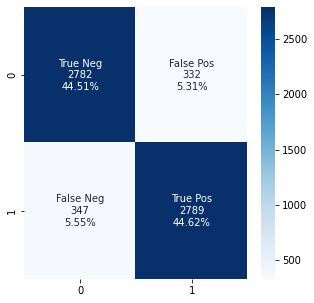

In [29]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

f = plt.figure()
f.set_figwidth(5)
f.set_figheight(5)


sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [30]:
from sklearn.metrics import roc_auc_score

In [31]:
roc_score = roc_auc_score(test_labels[6250:],pred_labels)
roc_score

0.8913671019949405